In [1]:
# To be able to use the quantools, due to my crap path names have to add to sys path
import sys
sys.path.insert(0, '/home/adam/Dropbox/2-creations/2-crafts/7-buidl/0-utils/quant_tools/code')

# IMPORT PACKAGES
from typing import Dict, List
from tools import QuantTools
import pandas as pd
import numpy as np
import pickle
import time
import gc


In [5]:
IN_FP     = '../data/clean/test_yhats_autoencoder.pkl'
LHS_COL         = 'r_ex_tp1'
df = pd.read_pickle(IN_FP)

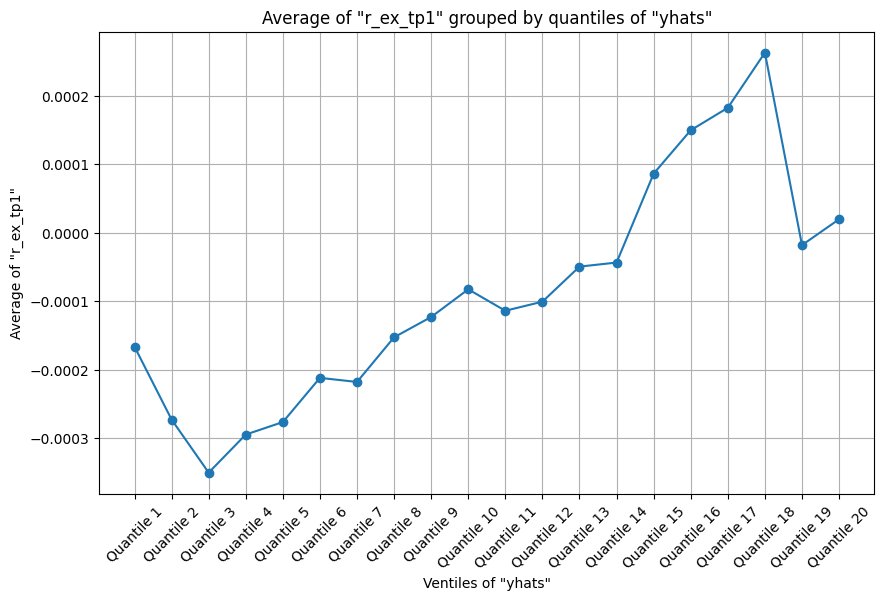

In [6]:
number_quantiles = 20

df = df.dropna()
df = df.sort_values(by=['date', 'asset'], ignore_index=True)
pos_df = QuantTools.formPortfolioPositionsQuantileLongShort(df, quantile=number_quantiles)
test_yhats = pos_df.yhats.values
test_ys = pos_df[LHS_COL].values
pos_df['returns'] = pos_df.position*pos_df[LHS_COL]
returns = pos_df.groupby('date')['returns'].sum()

import matplotlib.pyplot as plt

pos_df['yhats_quantiles'] = pd.qcut(pos_df['yhats'], number_quantiles, labels=False)

# Group by the deciles and compute the mean of 'r_ex_tp1'
grouped = pos_df.groupby('yhats_quantiles')['r_ex_tp1'].mean()

# Plotting
plt.figure(figsize=(10,6))
plt.plot(grouped, marker='o')
plt.xticks(np.arange(number_quantiles), ['Quantile ' + str(i+1) for i in range(number_quantiles)], rotation=45)
plt.title('Average of "r_ex_tp1" grouped by quantiles of "yhats"')
plt.xlabel('Ventiles of "yhats"')
plt.ylabel('Average of "r_ex_tp1"')
plt.grid(True)
plt.show()


In [7]:
# Ventiles

# -ALL:
# -- -1.47
# --5.8 bps over a 10.5 bps cost
# --10 sharpe after taking out 10.5 bps cost

1-np.mean(np.square(test_ys-test_yhats))/np.mean(np.square(test_ys))


-0.014714926085905411

In [8]:
QuantTools.calcGeomAvg(returns-0.00105)


0.0005809761044248685

In [9]:
QuantTools.calcSharpe(returns-0.00105, periods_in_year=24*365)

9.925866670734612

In [11]:
# -2022 2h:
# -- -1.47
# --4.3 bps over a 10.5 bps cost
# --9 sharpe after taking out 10.5 bps cost

returns = returns[-4380:]


1-np.mean(np.square(test_ys-test_yhats))/np.mean(np.square(test_ys))


-0.014714926085905411

In [12]:
QuantTools.calcGeomAvg(returns-0.00105)


0.00043231862542025823

In [13]:
QuantTools.calcSharpe(returns-0.00105, periods_in_year=24*365)

8.962321775306293

In [ ]:
# TODO UPDATE THIS OLDMESSY CODE WITH NEW PANEL

In [284]:
# Import packages
import pandas as pd
import pickle
import numpy as np
from openpyxl import load_workbook

In [285]:
def formFFQuintiles(test_df):
    # Build quintiles
    # -mcap is low to high preferable
    # -while r_t_2 is high to low is preferable
    test_df.loc[(test_df.tertile_r_t_2 == 3) &
                (test_df.tertile_mcap_t_1 == 1), 'quintile'] = 5
    test_df.loc[(test_df.tertile_r_t_2 == 3) &
                (test_df.tertile_mcap_t_1 == 2), 'quintile'] = 4
    test_df.loc[(test_df.tertile_r_t_2 == 2) &
                (test_df.tertile_mcap_t_1 == 1), 'quintile'] = 4
    test_df.loc[(test_df.tertile_r_t_2 == 3) &
                (test_df.tertile_mcap_t_1 == 3), 'quintile'] = 3
    test_df.loc[(test_df.tertile_r_t_2 == 2) &
                (test_df.tertile_mcap_t_1 == 2), 'quintile'] = 3
    test_df.loc[(test_df.tertile_r_t_2 == 1) &
                (test_df.tertile_mcap_t_1 == 1), 'quintile'] = 3
    test_df.loc[(test_df.tertile_r_t_2 == 2) &
                (test_df.tertile_mcap_t_1 == 3), 'quintile'] = 2
    test_df.loc[(test_df.tertile_r_t_2 == 1) &
                (test_df.tertile_mcap_t_1 == 2), 'quintile'] = 2
    test_df.loc[(test_df.tertile_r_t_2 == 1) &
                (test_df.tertile_mcap_t_1 == 3), 'quintile'] = 1

    return test_df

In [286]:
def formFFPortfolioResults(quintile_df, sheet_name):
    # Calculate value-weighted average returns for each quintile
    quintile_df['mcap_sum']     = quintile_df.groupby(['date', 'quintile'])['mcap_t_1'].transform('sum')
    quintile_df['weight']       = quintile_df.mcap_t_1 / quintile_df.mcap_sum
    quintile_df['quintile_r_t'] = quintile_df.weight * quintile_df.r_t
    quintile_df['quintile_r_t'] = quintile_df.groupby(['date', 'quintile'])['quintile_r_t'].transform('sum')
    results_df = quintile_df[['quintile', 'quintile_r_t']].drop_duplicates()

    # Form the output table
    output_df = pd.DataFrame(data = {'quintile': [1, 2, 3, 4, 5]})
    for quintile in [1, 2, 3, 4, 5]:
        weekly_returns = results_df[results_df.quintile == quintile].quintile_r_t.values
        output_df.loc[output_df.quintile == quintile, 'Real'] = np.product(weekly_returns+1)**(1/52)-1
        output_df.loc[output_df.quintile == quintile, 'Std'] = np.std(weekly_returns)
        output_df.loc[output_df.quintile == quintile, 'SR'] = np.sqrt(52)*np.mean(weekly_returns)/np.std(weekly_returns)

    # Output to Excel without overwriting the file
    book          = load_workbook('../4-output/portfolio_results.xlsx')
    writer        = pd.ExcelWriter('../4-output/portfolio_results.xlsx', engine='openpyxl') 
    writer.book   = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    output_df.to_excel(writer, sheet_name=sheet_name)
    writer.save()


In [287]:
def formQuintiles(test_df): 
    test_df = test_df.sort_values(by=['date', 'y_hat_t'])
    test_df['ranking'] = test_df.groupby(['date']).cumcount()+1
    test_df['counts'] = 1
    test_df['coins_per_week'] = test_df.groupby(['date']).counts.sum()
    test_df['ranking'] = test_df.ranking / test_df.coins_per_week
    test_df.loc[test_df.ranking <= 0.2, 'quintile'] = 1
    test_df.loc[(test_df.ranking > 0.2) & (test_df.ranking <= 0.4), 'quintile'] = 2
    test_df.loc[(test_df.ranking > 0.4) & (test_df.ranking <= 0.6), 'quintile'] = 3
    test_df.loc[(test_df.ranking > 0.6) & (test_df.ranking <= 0.8), 'quintile'] = 4
    test_df.loc[(test_df.ranking > 0.8), 'quintile'] = 5
    
    return test_df

In [359]:
def formPortfolioResults(quintile_df, sheet_name):
    # Calculate equal-weighted average returns for each quintile
    quintile_df['quintile_y_hat_t'] = quintile_df.groupby(['date', 'quintile'])['y_hat_t'].transform('mean')
    quintile_df['quintile_r_t'] = quintile_df.groupby(['date', 'quintile'])['r_t'].transform('mean')
    results_df = quintile_df[['quintile', 'quintile_y_hat_t', 'quintile_r_t']].drop_duplicates()

    # Form the output table
    output_df = pd.DataFrame(data = {'quintile': [1, 2, 3, 4, 5]})
    for quintile in [1, 2, 3, 4, 5]:
        pred_returns = results_df[results_df.quintile == quintile].quintile_y_hat_t.values
        weekly_returns = results_df[results_df.quintile == quintile].quintile_r_t.values
        output_df.loc[output_df.quintile == quintile, 'Pred'] = np.product(pred_returns+1)**(1/52)-1
        output_df.loc[output_df.quintile == quintile, 'Real'] = np.product(weekly_returns+1)**(1/52)-1
        output_df.loc[output_df.quintile == quintile, 'Std'] = np.std(weekly_returns)
        output_df.loc[output_df.quintile == quintile, 'SR'] = np.sqrt(52)*np.mean(weekly_returns)/np.std(weekly_returns)

    # Output to Excel without overwriting the file
    book          = load_workbook('../4-output/portfolio_results.xlsx')
    writer        = pd.ExcelWriter('../4-output/portfolio_results.xlsx', engine='openpyxl') 
    writer.book   = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    output_df.to_excel(writer, sheet_name=sheet_name)
    writer.save()

In [412]:
def outputBenchmarks(test_df):
    # Calculate equal weighted return statistics
    eql_wght_weekly_returns = test_df.groupby('date').r_t.mean().values
    eql_wght_real = np.product(eql_wght_weekly_returns+1)**(1/52)-1
    eql_wght_std = np.std(eql_wght_weekly_returns)
    eql_wght_sr = np.sqrt(52)*np.mean(eql_wght_weekly_returns)/eql_wght_std

    # Calculate mcap weighted return statistics
    test_df['mcap_sum'] = test_df.groupby(['date'])['mcap_t_1'].transform('sum')
    test_df['weight']   = test_df.mcap_t_1 / test_df.mcap_sum
    test_df['mcap_r_t'] = test_df.weight * test_df.r_t
    test_df['mcap_r_t'] = test_df.groupby(['date'])['mcap_r_t'].transform('sum')
    mcap_wght_weekly_returns = test_df[['mcap_r_t']].drop_duplicates().mcap_r_t.values
    mcap_wght_real = np.product(mcap_wght_weekly_returns+1)**(1/52)-1
    mcap_wght_std = np.std(mcap_wght_weekly_returns)
    mcap_wght_sr = np.sqrt(52)*np.mean(mcap_wght_weekly_returns)/mcap_wght_std

    # Form output dataframe
    output_df = pd.DataFrame(data={'weights': ['equal', 'mcap']})
    output_df.loc[output_df.weights == 'equal', 'Real'] = eql_wght_real 
    output_df.loc[output_df.weights == 'equal', 'Std'] = eql_wght_std
    output_df.loc[output_df.weights == 'equal', 'SR'] = eql_wght_sr
    output_df.loc[output_df.weights == 'mcap', 'Real'] = mcap_wght_real 
    output_df.loc[output_df.weights == 'mcap', 'Std'] = mcap_wght_std
    output_df.loc[output_df.weights == 'mcap', 'SR'] = mcap_wght_sr

    # Output to Excel without overwriting the file
    book          = load_workbook('../4-output/portfolio_results.xlsx')
    writer        = pd.ExcelWriter('../4-output/portfolio_results.xlsx', engine='openpyxl') 
    writer.book   = book
    writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
    output_df.to_excel(writer, sheet_name='benchmarks')
    writer.save()

In [ ]:
# TODO pull helper functions out of first cell in backtest notebook to create a basic class with GPT's help of quant tools that i put in some folder on my computer of my python methods
# maybe move into a folder where i keep my python tools
# make it a class so i import as needed
# create a repo for that
# ask chatgpt how to structure it in various python files
# maybe ask for a template folder and file structure for the library
# add a pointer to it for the automa capital stuff
# TODO Move helper functions to a call in utils file.


In [413]:
# Import FF and CA yhats
pik_ff = '../3-data/clean/ff-rankings-returns.pkl' 
with open(pik_ff, "rb") as f:
    ff_data_in = pickle.load(f)
    
ff_yhats_df, ff_test_df, ff_return_df = ff_data_in

pik_ca = '../3-data/clean/autoencoders-yhats-returns.pkl' 
with open(pik_ca, "rb") as f:
    ca_data_in = pickle.load(f)
    
opt_hps_list, test_dfs_list, returns_dfs_list = ca_data_in

# Import other benchmarks

# TODO: CMC 200
# TODO: BTC
# TODO: ETH
# TODO: S&P 500

# Output FF results
test_df = ff_test_df.copy()
quintile_df = formFFQuintiles(test_df)
formFFPortfolioResults(quintile_df, sheet_name = 'raw_ff')

# Output autoencoder results
for i in range(len(test_dfs_list)):
    test_df = test_dfs_list[i]
    opt_hps = opt_hps_list[i]
    num_hidden_layer = opt_hps['number_hidden_layer']
    num_factor = opt_hps['number_factor']
    sheet_name = 'raw_autoencoder-hl_' + str(num_hidden_layer) + '-fac_' + str(num_factor)
    
    quintile_df = formQuintiles(test_df)
    formPortfolioResults(quintile_df, sheet_name)

# Output benchmarks
outputBenchmarks(ff_test_df)

# TODO: ENSURE I REPORT THE RETURN AND SHARPE AND OTHER METRICS FOR ALL BENCHMARKS:
# -FF, CA, CMC 200, EQUAL WEIGHTS FROM SAME UNIVERSE, MCAP WEIGHTS FROM SAME UNIVERSE, BTC, ETH, S&P 500

# Report out for OOS: (maybe do some of these in a separate script?)
# --return weighted by mcap and equal weights
# --sharpe for both equal and mcap weights
# --source of excess return e.g. distri of each week-asset holding return with naming top returns asset-weeks
# --max DD
# --fees
# --min/Q1-Q3/max portfolio weight each week plotted
# --number of transactions per week
# --portfolio turnover
# --portfolio return per month
# --fees per week/month/overall